<a href="https://colab.research.google.com/github/csgm2328/Emily/blob/master/Stock_LSTM_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#import

In [2]:
get_ipython().run_line_magic('matplotlib', 'inline')
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader.data as pdr #data 받아오는 api 라이브러리
from pandas import json_normalize
import numpy as np
import plotly as py
import plotly.graph_objs as go
import requests
from datetime import datetime
import traceback
import os
from keras import metrics
from keras.layers import *
from keras.models import *
from keras.callbacks import *
from pandas.util.testing import assert_frame_equal
from sklearn.preprocessing import MinMaxScaler

plt.style.use('bmh')

/usr/local/lib/python3.6/dist-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


#Request URL API

In [13]:
#ETF 종목
#etf_url = requests.get('https://finance.naver.com/api/sise/etfItemList.nhn')
#stok.js = etf_url.json()
#stock_data = json_normalize(stock_js['result']['etfItemList'])
#stock_data

stock_url = pd.read_html('http://kind.krx.co.kr/corpgeneral/corpList.do?method=download&searchType=13', header=0)[0] #[0] 없으면 DataFrame이 아니라 list
stock_url.종목코드 = stock_url.종목코드.map('{:06d}'.format)
stock_url = stock_url[['회사명', '종목코드']] #필요한 두가지만
stock_url = stock_url.rename(columns={'회사명':'name', '종목코드':'code'})

In [14]:
item_name = '씨젠'
code = stock_url.query("name=='{}'".format(item_name))['code'].to_string(index=False).strip() #strip 앞뒤공백제거
#dr_code = code + '.KS' #DataReader용, 코스닥은 KQ
dr_code = code + '.KQ'
print(item_name, dr_code)

씨젠 096530.KQ


#DataReader crawling

In [15]:
#URL 없이 상당히 쉬운 DataReader를 이용한 크롤링
start = (2012, 1, 1)
start_date = datetime(*start)
end = datetime.today()
df = pdr.DataReader(dr_code, 'yahoo', start_date, end) #031430.KS 신세계인터내셔날, 코스닥 데이터는 왜 오늘치밖에 안나오냐?
df.astype(np.int64)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-01-02,40213,39466,39946,39893,64611,39893
2012-01-03,40320,39466,40000,39466,110179,39466
2012-01-04,40053,38613,40000,38666,181605,38666
2012-01-05,39146,37813,38933,37920,137610,37920
2012-01-06,38720,37866,38186,37920,77102,37920
...,...,...,...,...,...,...
2018-01-26,40100,39050,39800,39550,367634,39550
2018-01-29,40500,39150,39900,39250,373126,39250
2018-01-30,39200,37500,39200,37750,467383,37750


In [17]:
from datetime import timedelta
(datetime.today() - datetime(*start)).days

3192

In [7]:
# from pandas.tseries.offsets import CDay

# # Creating a series of dates between the boundaries 
# # by using the custom calendar
# se = pd.bdate_range(start=start, 
#                     end=datetime.today(),
#                     freq=CDay(calendar=cal)).to_series()
# # Counting the number of working days by month
# se.groupby(se.dt.month).count().head()

In [3]:
cd /content/drive/My Drive/Colab Notebooks/KOSDAQ200

/content/drive/My Drive/Colab Notebooks/KOSDAQ200


In [47]:
df.sort_index(0, ascending=False)
df

,0,1,2,3,4,5,6
0,날짜,Close,전일비,시가,고가,저가,거래량
1,2020.09.24,32300,1000,32700,33150,32150,310254
2,2020.09.23,33300,700,33000,33450,32000,307264
3,2020.09.22,32600,1000,33550,33600,32350,361095
4,2020.09.21,33600,250,33550,34600,33300,467234
...,...,...,...,...,...,...,...
1075,2016.05.16,20300,750,19600,20500,19550,1.10508e+06
1076,2016.05.13,19550,500,18950,19700,18800,1.1764e+06
1077,2016.05.12,19050,900,18100,19300,17850,1.2809e+06
1078,2016.05.11,18150,300,17950,18350,17700,763921


In [6]:
df = pd.read_csv('240810 원익IPS.csv')
# row = pd.DataFrame([['날짜',	'Close',	'전일비',	'시가',	'고가',	'저가',	'거래량']])
# x = np.asarray(row)
# y = np.asarray(df)
# x = np.vstack((x,y))
df = pd.DataFrame(data = np.asarray(df), columns=['날짜',	'종가',	'전일비',	'시가',	'고가',	'저가',	'거래량'])
# Date  Close		Diff  Open	High  Low Volume
df

,날짜,Close,전일비,시가,고가,저가,거래량
0,2020.09.24,32300,1000,32700,33150,32150,310254
1,2020.09.23,33300,700,33000,33450,32000,307264
2,2020.09.22,32600,1000,33550,33600,32350,361095
3,2020.09.21,33600,250,33550,34600,33300,467234
4,2020.09.18,33350,50,33450,33750,33100,277956
...,...,...,...,...,...,...,...
1074,2016.05.16,20300,750,19600,20500,19550,1.10508e+06
1075,2016.05.13,19550,500,18950,19700,18800,1.1764e+06
1076,2016.05.12,19050,900,18100,19300,17850,1.2809e+06
1077,2016.05.11,18150,300,17950,18350,17700,763921


In [38]:
row = pd.DataFrame([['날짜',	'Close',	'전일비',	'시가',	'고가',	'저가',	'거래량']])
c = [['날짜',	'Close',	'전일비',	'시가',	'고가',	'저가',	'거래량']]
x = np.asarray(row)
y = np.asarray(df)
x = np.vstack((x,y))
x.shape

(1080, 7)

In [9]:
df = pd.read_csv('240810 원익IPS.csv')
scaler = MinMaxScaler()
real_price = df['32300.0'].tolist()
price = scaler.fit_transform(df[['32300.0']]).reshape(-1).tolist()
print('오늘은',datetime.today(), real_price[-1], len(real_price), '개')

오늘은 2020-09-27 18:59:52.167355 17850.0 1079 개


#Args

In [21]:
from keras import optimizers
#args
n_Memcell = 128
window_size = 100 #여기도 60win에서 두번 실패
b_state = True
predict_day = 10
#return_sequences = 여러 층일때, 각 시퀀스에서 출력할지 말지 결정. many to many 일때

n_batch = 1
n_epoch =  1000#colab 12시간 제한 특성 때문
n_drop = 0.2
learning_rate = 0.001 #default
ac_func = 'relu'
loss_func = 'mse'
optim_func = optimizers.Adam(lr=learning_rate)
#decay_rate = 0.001 #신경망에서는 수학적으로 동일한 L2 놈을 대신사용한다.
#optim_func = optimizers.Adadelta(learning_rate = learning_rate) #0.1, 0.001 둘다 과소적합
item_name = '원익IPS'
start = (2012, 1, 1)
start_date = datetime(*start)
args_str = '['+str(datetime.date(start_date)) + ' ~ ' + str(datetime.date(datetime.today())) + '] ' + str(n_Memcell) + 'cell '+ str(window_size) +'win '+ str(n_batch) +'bat ' + str(n_epoch) + 'ep '+ str(n_drop) + 'drop ' + str(b_state) + ' ' + str(learning_rate) + 'lr'
Title = item_name + ': ' + args_str
Title

'원익IPS: [2012-01-01 ~ 2020-09-27] 128cell 100win 1bat 1000ep 0.2drop True 0.001lr'

#make DataSet

In [22]:
x = []  #5일의 데이터를 넣고 다음날을 예측하는 방식 (특징벡터 - 훈련집합)
y = []  #5+1일의 데이터를 넣고 (결과값 - 훈련집합)

for i in range(len(price) - window_size):   #1916-5 = 1911 Range는 마지막 1910까지임
    x.append([price[i+j] for j in range(window_size)])
    y.append(price[window_size + i])
    
#print(x[-1])  # [1911,5] list
#print(price[-1]) #[1916, 1]
#print(y[-1])  #[1911, 1]

In [23]:
x = np.asarray(x)
y = np.asarray(y)
print(x.shape) # [1911,5] list
print(type(y))

(979, 100)
<class 'numpy.ndarray'>


In [24]:
train_test_split = int(len(x)*0.3) #1200개에서 1357개로 증가후에 acc: 0.0017 --> 0.0015
split_pt = train_test_split + window_size

x_test = x[:train_test_split, :]
y_test = y[:train_test_split]

x_train = x[train_test_split:, :]
y_train = y[train_test_split:]

xtrain = x_train.reshape((x_train.shape[0], x_train.shape[1], 1)) # 2차원 데이터 3차원화, LSTM의 데이터 생성할때 주의해야하는 포인트, [sequence,  batch, input_dim]
xtest =  np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))  #test 집합을 늘리면 미래를 예측할 수 있을까?

print(xtrain.shape)
print(x_test.shape) 

(686, 100, 1)
(293, 100)


In [25]:
#history Metrics
import keras
class CustomHistory(keras.callbacks.Callback):
  def init(self):
    self.losses = []
    self.accs = []
  def on_epoch_end(self, batch, logs={}):
    self.losses.append(logs.get('loss'))
    self.accs.append(logs.get('acc'))   

In [26]:
cd /content/drive/My Drive/Colab Notebooks/LSTM_models

/content/drive/My Drive/Colab Notebooks/LSTM_models


In [27]:
# #Best Args 찾기
# %%time
# xaxes = []
# train_maes = []
# test_maes = []

# for w in range(5, 100, 5):
#   #Expriment args
#   window_size = w
#   #n_epoch = n

#   #make Dataset
#   x = []  #5일의 데이터를 넣고 다음날을 예측하는 방식 (특징벡터 - 훈련집합)
#   y = []  #5+1일의 데이터를 넣고 (결과값 - 훈련집합)

#   for i in range(len(price) - window_size):   #1916-5 = 1911 Range는 마지막 1910까지임
#     x.append([price[i+j] for j in range(window_size)])
#     y.append(price[window_size + i])
  
#   x = np.asarray(x)
#   y = np.asarray(y)

#   train_test_split = int(len(x)*0.7) #1200개에서 1357개로 증가후에 acc: 0.0017 --> 0.0015

#   x_train = x[:train_test_split, :]
#   y_train = y[:train_test_split]

#   x_test = x[train_test_split:, :]
#   y_test = y[train_test_split:]

#   xtrain = x_train.reshape((x_train.shape[0], x_train.shape[1], 1)) # 2차원 데이터 3차원화, LSTM의 데이터 생성할때 주의해야하는 포인트, [sequence,  batch, input_dim]
#   xtest =  np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))  #test 집합을 늘리면 미래를 예측할 수 있을까?

#   #model define
#   model = Sequential()
#   model.add(LSTM(n_Memcell, batch_input_shape =(n_batch, window_size, 1), stateful=b_state))
#   model.add(Dropout(n_drop))
#   model.add(Activation(ac_func))
#   model.add(Dense(1))
#   model.compile(loss=loss_func, optimizer=optim_func, metrics=['mae', 'acc'])

#   #training
#   report = CustomHistory()
#   report.init()
#   early_stopping = keras.callbacks.EarlyStopping(monitor='loss', min_delta=0.0001, patience=10, mode='auto') 

#   for i in range(n_epoch):
#       #print('[%d] ' %i)
#       model.fit(xtrain, y_train, epochs=1, batch_size=n_batch, callbacks=[report, early_stopping],verbose=2)
#       model.reset_states()

#   #save the model
#   args_str = '['+str(datetime.date(start_date)) + ' ~ ' + str(datetime.date(datetime.today())) + '] ' + str(n_Memcell) + 'cell '+ str(window_size) +'win '+ str(n_batch) +'bat ' + str(n_epoch) + 'ep '+ str(n_drop) + 'drop ' + str(b_state) + ' ' + str(learning_rate) + 'lr'
#   Title = item_name + ': ' + args_str
#   from keras.models import load_model
#   model.save(Title + '.h5')

#   #evaluate
#   trainScore = model.evaluate(xtrain, y_train, batch_size=n_batch, verbose=0)
#   testScore = model.evaluate(xtest, y_test, batch_size=n_batch, verbose=0)
#   #print('%d epoch' %n_epoch)  #Expriment args
#   print('%d win' %window_size) #Expriment args
#   print("(%.5f, %.5f)" %(trainScore[1], testScore[1]))
#   print(np.average(report.losses))
  
#   #axis
#   xaxes.append(w) #Expriment args
#   train_maes.append(trainScore[1])
#   test_maes.append(testScore[1])

# #graph
# train_ax = plt.subplot()
# test_ax = train_ax.twinx()

# train_ax.plot(xaxes, train_maes, 'y', label='train_mae')
# test_ax.plot(xaxes, test_maes, 'b', label='test_mae')

# #train_ax.set_xlabel('? window_size fixing ' + str(n_epoch) + 'ep') # epoch 고정
# train_ax.set_xlabel('? epoch fixing '+ str(window_size) + 'win') # window_size 고정
# #train_ax.set_ylabel('train_mae')
# #test_ax.set_ylabel('test_mae')

# train_ax.legend(loc='best')
# test_ax.legend(loc='best')

# plt.show()


In [28]:
#Model Define
#LSTM은 보통 train_acc가 0.0017로 측정됨

model = Sequential()
#model.add(LSTM(128, batch_input_shape=(n_batch, window_size, 1), stateful=b_state, kernel_regularizer=keras.regularizers.l2(0.001)))
model.add(LSTM(n_Memcell, batch_input_shape =(n_batch, window_size, 1), stateful=b_state))
model.add(Dropout(n_drop))
#model.add(Activation(ac_func))
model.add(Dense(1))

model.compile(loss=loss_func, optimizer=optim_func, metrics=['mae', 'acc'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (1, 128)                  66560     
_________________________________________________________________
dropout_1 (Dropout)          (1, 128)                  0         
_________________________________________________________________
dense_1 (Dense)              (1, 1)                    129       
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________


In [29]:
#60win 1200ep 7h 54m
#1815개 60win 1500ep 10h 54m (한계)
#1469개 55win 2000ep 9h 56m
#1421개 96win 5000ep 8h 17m
#1402개 128win 7s/ep

%%time
report = CustomHistory()
report.init()
early_stopping = keras.callbacks.EarlyStopping(monitor='loss', min_delta=0.0001, patience=10, mode='auto') #loss가 증가하면 훈련 그만하기 loss는 증가안함 acc가 감소하면으로 바꿔주기 
#min_delta 0.005이상 변화없으면 끝내도록

for i in range(n_epoch):
    print('[%d] ' %i)
    model.fit(xtrain, y_train, epochs=1, batch_size=n_batch, callbacks=[report, early_stopping],verbose=2)
    model.reset_states()



[0] 
686/686 - 3s - loss: 0.0076 - mae: 0.0632 - acc: 0.0029
[1] 
686/686 - 3s - loss: 0.0049 - mae: 0.0534 - acc: 0.0029
[2] 
686/686 - 3s - loss: 0.0036 - mae: 0.0460 - acc: 0.0029
[3] 
686/686 - 3s - loss: 0.0030 - mae: 0.0423 - acc: 0.0029
[4] 
686/686 - 3s - loss: 0.0029 - mae: 0.0409 - acc: 0.0029
[5] 
686/686 - 3s - loss: 0.0028 - mae: 0.0402 - acc: 0.0029
[6] 
686/686 - 3s - loss: 0.0025 - mae: 0.0384 - acc: 0.0029
[7] 
686/686 - 3s - loss: 0.0024 - mae: 0.0365 - acc: 0.0029
[8] 
686/686 - 3s - loss: 0.0022 - mae: 0.0355 - acc: 0.0029
[9] 
686/686 - 3s - loss: 0.0023 - mae: 0.0374 - acc: 0.0029
[10] 
686/686 - 3s - loss: 0.0021 - mae: 0.0355 - acc: 0.0029
[11] 
686/686 - 3s - loss: 0.0021 - mae: 0.0350 - acc: 0.0029
[12] 
686/686 - 3s - loss: 0.0021 - mae: 0.0349 - acc: 0.0029
[13] 
686/686 - 3s - loss: 0.0019 - mae: 0.0332 - acc: 0.0029
[14] 
686/686 - 3s - loss: 0.0019 - mae: 0.0323 - acc: 0.0029
[15] 
686/686 - 3s - loss: 0.0017 - mae: 0.0327 - acc: 0.0029
[16] 
686/686 - 3s

In [30]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:
cd /content/drive/My Drive/Colab Notebooks/LSTM_models

/content/drive/My Drive/Colab Notebooks/LSTM_models


In [32]:
from keras.models import load_model
model.save(Title + '.h5')

In [33]:
 #5개의 가격이랑 mse loss를 취한 그 loss를 각 시퀀스에 대해 계산하고 평균을 낸 loss가 곧바로 정밀도일까?
# 변동율예측기 정확도를 %로 평가
# log(xt+1) - log(x_last+1) = exp( log( xt/x_last) ) = xt/x_last
# x_last = 10 pred = 12, true = 13 metric = -1/10 = 10%의 loss

def metric(y_pred, y_true): #절대 오차값 합의 평균으로 acc 평가
    perc_y_pred = np.exp(y_pred.cpu().detach().numpy())
    perc_y_true = np.exp(y_true.cpu().detach().numpy())
    mae = mean_absolute_error(perc_y_true, perc_y_pred, multioutput='raw_values') #오차 절대값의 합
    return mae*100

In [34]:
trainScore = model.evaluate(xtrain, y_train, batch_size=n_batch, verbose=0)
testScore = model.evaluate(xtest, y_test, batch_size=n_batch, verbose=0)
print("mae: (%.5f, %.5f)" %(trainScore[1], testScore[1]))
#trainScore[1]

mae: (0.02554, 0.02991)


In [35]:
print(trainScore)
testScore

[0.0010725182946771383, 0.025541171431541443, 0.0029154520016163588]


[0.0015338786179199815, 0.029906412586569786, 0.0]

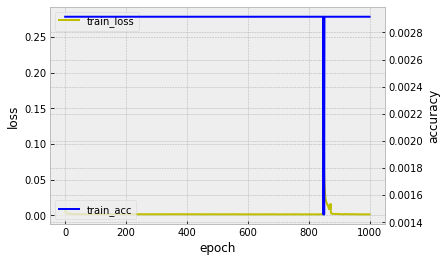

In [36]:
loss_ax = plt.subplot()
acc_ax = loss_ax.twinx()

loss_ax.plot(report.losses, 'y', label='train_loss')
acc_ax.plot(report.accs, 'b', label='train_acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()
#주식 특징집합의 train_acc가 0.005밖에 안된다

In [37]:
#train, test prediction
train_pred = model.predict(xtrain,batch_size=n_batch) # x[0~window_size-1] 만큼의 특징벡터를 학습해서 학습데이터 수 
#model.reset_states()
test_pred = model.predict(xtest,batch_size=n_batch)
#model.reset_states()
real_test_pred = scaler.inverse_transform(test_pred)

In [38]:
tom_real = xtrain[-1]
tom_real = np.vstack((tom_real[1:], price[-1])) #test_pred[-1] 대신에 price[-1]
tom_real.shape

tom_pred = xtest[-1]
tom_pred = np.vstack((tom_pred[1:], test_pred[-1])) #마지막 데이터에 예측값
tom_pred.shape

(100, 1)

In [39]:
#학습된 모델로 예측하기
seq_in = tom_real #오늘꺼 예측자를 마지막 데이터로 추가해준 Input 샘플 or real 데이터 추가
#first_in = xtest[-1]  #test 샘플 마지막. 여기에다가 다음날 pred를 추가해줄거임
after_pred = np.zeros((predict_day,1))

for i in range(predict_day):
  sample_in = seq_in.reshape(1,window_size,1)
  after = model.predict(sample_in, batch_size=n_batch)
  model.reset_states()
  seq_in = np.vstack((seq_in[1:], after))
  after_pred[i] = after
  
#model.reset_states()
real_after_pred = scaler.inverse_transform(after_pred)

In [40]:
# #학습결과 그래프

# plt.figure(figsize=(20,10))
# plt.plot(price)
# #price = np.asarray(price)

# train_loss = 0.0
# test_loss = 0.0

# for i in range(train_test_split):
#   train_loss += price[i+window_size] - train_pred[i]  #5~1204까지
# for j in range(len(test_pred)-1):
#   test_loss += price[j+split_pt] - test_pred[j] # 1205 ~ 1915까지 
# train_loss /= train_test_split
# test_loss /= len(test_pred)

# #train_acc += metric(train_pred, y)
# #test_acc += metric(test_pred, y)

# plt.plot(np.arange(0, len(price),1), price, color='b')
# plt.plot(np.arange(window_size, split_pt, 1), train_pred, color='g')
# plt.plot(np.arange(split_pt, split_pt + len(test_pred), 1), test_pred, color='r')
# plt.plot(np.arange(len(price), len(price) + predict_day, 1), after_pred, color='y')

# print(
#     '현재 종가: ', price[-1], #x는 마지막값 누락
#     '예측 종가: ', test_pred[-1],
#     '훈련 loss: ', train_loss,
#     '테스트 loss: ', test_loss,
#     '마지막 오차: ',  price[-1] - test_pred[-1], sep='\n')

현재 종가: 
0.04496788008565311
예측 종가: 
[0.2600645]
오 차 율: 
[-4.7833395]


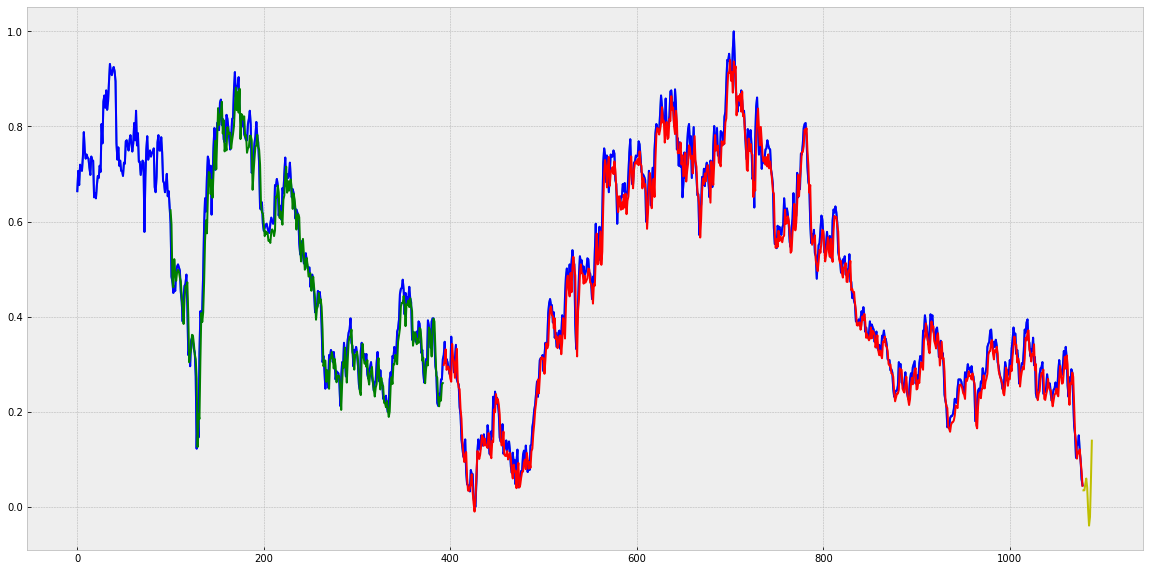

In [41]:
#학습결과 그래프
plt.figure(figsize=(20,10))
plt.plot(price)

plt.plot(np.arange(0, len(price),1), price, color='b')
# plt.plot(np.arange(window_size, split_pt, 1), train_pred, color='g')
# plt.plot(np.arange(split_pt, split_pt + len(test_pred), 1), test_pred, color='r')
# plt.plot(np.arange(len(price), len(price) + len(after_pred), 1), after_pred, color='y')
plt.plot(np.arange(window_size, split_pt, 1), test_pred, color='g')
plt.plot(np.arange(split_pt, split_pt + len(train_pred), 1), train_pred, color='r')
plt.plot(np.arange(len(price), len(price) + len(after_pred), 1), after_pred, color='y')

print(
    '현재 종가: ', price[-1], #x는 마지막값 누락
    '예측 종가: ', test_pred[-1],
    '오 차 율: ',  (price[-1] - test_pred[-1]) / price[-1], sep='\n')

In [42]:
# trace = go.Scatter(x=np.arange(0,len(price),1), y=price, #0~1915까지 해야함 재정규화로 matrix되면 reshape해주어 1차행렬로 만들어야함
# mode = 'lines', name='original')
# trace2 = go.Scatter(x=np.arange(window_size,split_pt,1), y=train_pred.reshape(train_test_split), #(5,1205,1) 이지만, 5~1204까지 적용 다 마찬가지
# mode = 'lines', name='train')
# trace3 = go.Scatter(x=np.arange(split_pt,split_pt + len(test_pred),1), y=test_pred.reshape(len(test_pred)),  #1205~1915
# mode = 'lines', name='pred')
# trace4 = go.Scatter(x=np.arange(len(price), len(price)+predict_day, 1), y =after_pred.reshape(len(after_pred)),
# mode = 'lines', name= 'after_pred')

# data = [trace, trace2, trace3, trace4]
# layout = go.Layout(title=Title)

# fig = go.Figure(data=data, layout=layout)
# #py.offline.plot(fig, show_link=True, filename=Title + '.html')
# py.offline.iplot(fig)

# from google.colab import files
# #files.download(filename=Title+'.html')

In [43]:
trace = go.Scatter(x=np.arange(0,len(price),1), y=price, #0~1915까지 해야함 재정규화로 matrix되면 reshape해주어 1차행렬로 만들어야함
mode = 'lines', name='actual')
trace2 = go.Scatter(x=np.arange(window_size,split_pt,1), y=test_pred.reshape(len(test_pred)), #(5,1205,1) 이지만, 5~1204까지 적용 다 마찬가지
mode = 'lines', name='train')
trace3 = go.Scatter(x=np.arange(split_pt,split_pt + len(train_pred),1), y=train_pred.reshape(len(train_pred)),  #1205~1915
mode = 'lines', name='prediction')
trace4 = go.Scatter(x=np.arange(split_pt +len(train_pred), split_pt + len(train_pred) + len(after_pred), 1), y =after_pred.reshape(len(after_pred)),
mode = 'lines', name= 'after_pred')

data = [trace, trace2, trace3, trace4]
layout = go.Layout(title=Title)
fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig) #그래프 출력 
#py.offline.plot(fig, show_link = True, filename = Title + '.html') #다른이름으로 지정

from google.colab import files
import os

#os.rename('temp-plot.html', rename)
#files.download(filename=Title +'.html') #다운로드

In [44]:
print('현재 종가: ', real_price[-1], #df, series는 -1 인덱싱 안됨
      '\n다음 예측가격: \n', real_after_pred.astype(int))

현재 종가:  17850.0 
다음 예측가격: 
 [[17599]
 [17603]
 [17908]
 [18181]
 [17745]
 [16653]
 [15869]
 [16293]
 [18048]
 [20042]]


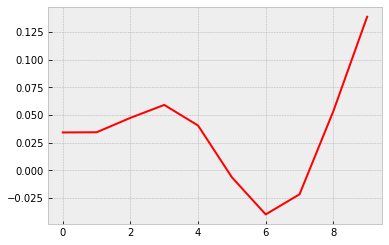

In [45]:
plt.plot(np.arange(0,len(after_pred), 1), after_pred, color='red')

#2020-07-16 128cell 60win 1bat 1500ep 0.2drop True(0.0068, 0.0147)
현재 종가:  54700.0 
다음 예측가격: 
 [
 [54893.63160133]
 [54766.0091877 ]
 [54602.36825943]
 [54522.68424034]
 [54475.19669533]
 [54446.21725082]
 [54428.90172005]
 [54419.37861443]
 [54414.94865417]
 [54415.34714699]]

 #'삼성전자: 2020-07-21 128cell 55win 1bat 2000ep 0.2drop True.h5' (0.00000, 0.00174) train:추종, test: 1998~2012(과잉) 제외 추종, after: 미세하락
학습률을 낮추니까 확실히 과잉이 줄어듬.
#주식데이터로는 완전적합이 발생하지 않는다 아니였다 다른 주식은 된다

#7/29일 유의미 after 발견
[2020-07-30] 128cell 25win 1bat 2000ep 0.2drop True 0.001lr
train_loss가 자연수로 튄 구간있지만, train,test 완전추종
값 오차율: 1.29%
방향정확도: 48.40%
MCC: 0.05

값 오차율: 1.42%
방향정확도: 44.76%
MCC: -0.04

값 오차율: 0.98%
방향정확도: 66.67%
MCC: 0.45


[2012-01-01 ~ 2020-07-31] 128cell 10win 1bat 2000ep 0.2drop True 0.001lr
train, test: 완전추종, after 무의미

[2014-01-01 ~ 2020-08-04] 128cell 10win 1bat 4000ep 0.2drop True 0.001lr
3h 40m밖에 안해서 과잉적합이 발생하지 않은건가? acc:0.0018로 증가
train, test: 완전추종, after: 무의미

[2014-01-01 ~ 2020-08-05] 128cell 10win 1bat 3000ep 0.3drop True 0.001lr
train, test: 완전추종
값 오차율: 1.24%
방향정확도: 55.31%
MCC: 0.10

값 오차율: 1.41%
방향정확도: 47.16%
MCC: -0.02

[2014-01-01 ~ 2020-08-07] 128cell 15win 1bat 6000ep 0.3drop True 0.001lr
과잉적합 학습실패 추종 아닌 구간도 없음

[2014-01-01 ~ 2020-08-17] 128cell 72win 1bat 1300ep 0.2drop True 0.001lr
btc로 1400ep한거는 완전추종되었는데 이건 왜이럴까?